In [ ]:
import math
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
from math import sqrt
import statsmodels.api as sm
import matplotlib.pyplot as plt
!pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00


In [ ]:
df=yf.download(tickers="BTC-USD",period="60d",interval='5m')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
DF=df

In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-01-25 00:00:00+00:00,40075.550781,40075.550781,40051.703125,40051.703125,40051.703125,0
2024-01-25 00:05:00+00:00,40063.527344,40063.527344,40047.363281,40047.363281,40047.363281,190601216
2024-01-25 00:10:00+00:00,40046.449219,40065.203125,40046.449219,40062.292969,40062.292969,0
2024-01-25 00:15:00+00:00,40060.019531,40092.191406,40060.019531,40076.687500,40076.687500,0
2024-01-25 00:20:00+00:00,40053.832031,40053.832031,40042.699219,40052.207031,40052.207031,0
...,...,...,...,...,...,...
2024-03-24 15:15:00+00:00,65506.480469,65519.746094,65478.300781,65479.660156,65479.660156,5496832
2024-03-24 15:20:00+00:00,65473.953125,65537.171875,65473.953125,65537.171875,65537.171875,1744896
2024-03-24 15:25:00+00:00,65512.644531,65614.507812,65512.644531,65614.507812,65614.507812,1359872


Splitting data

In [ ]:
train_data=df.iloc[:-20,3]
test_data=df.iloc[-20:,3]

Plot

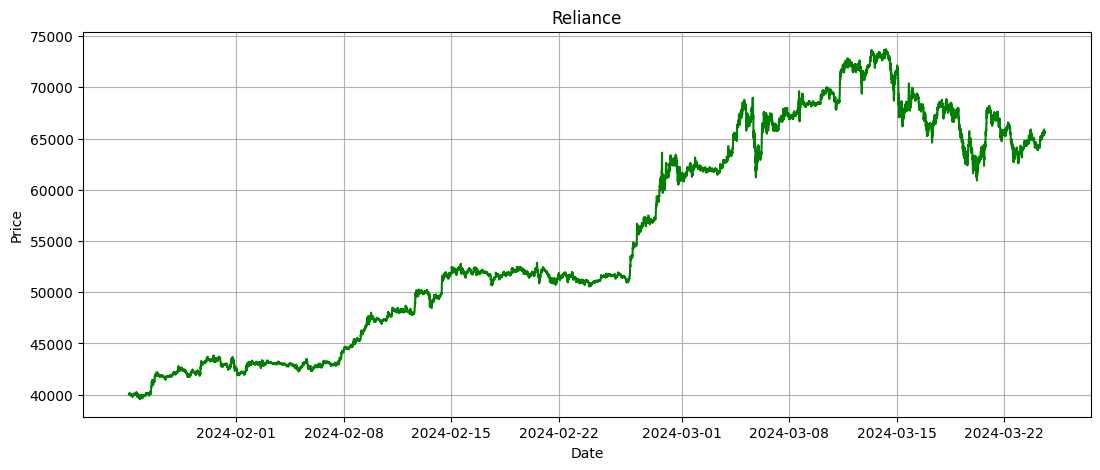

In [ ]:
plt.figure(figsize=(13,5))
plt.grid(True)
#plt.plot(result['predictions'],c='red')
plt.plot(df.Close,c='green')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Reliance")
plt.show()

Trend, Seasonal, Residual plots

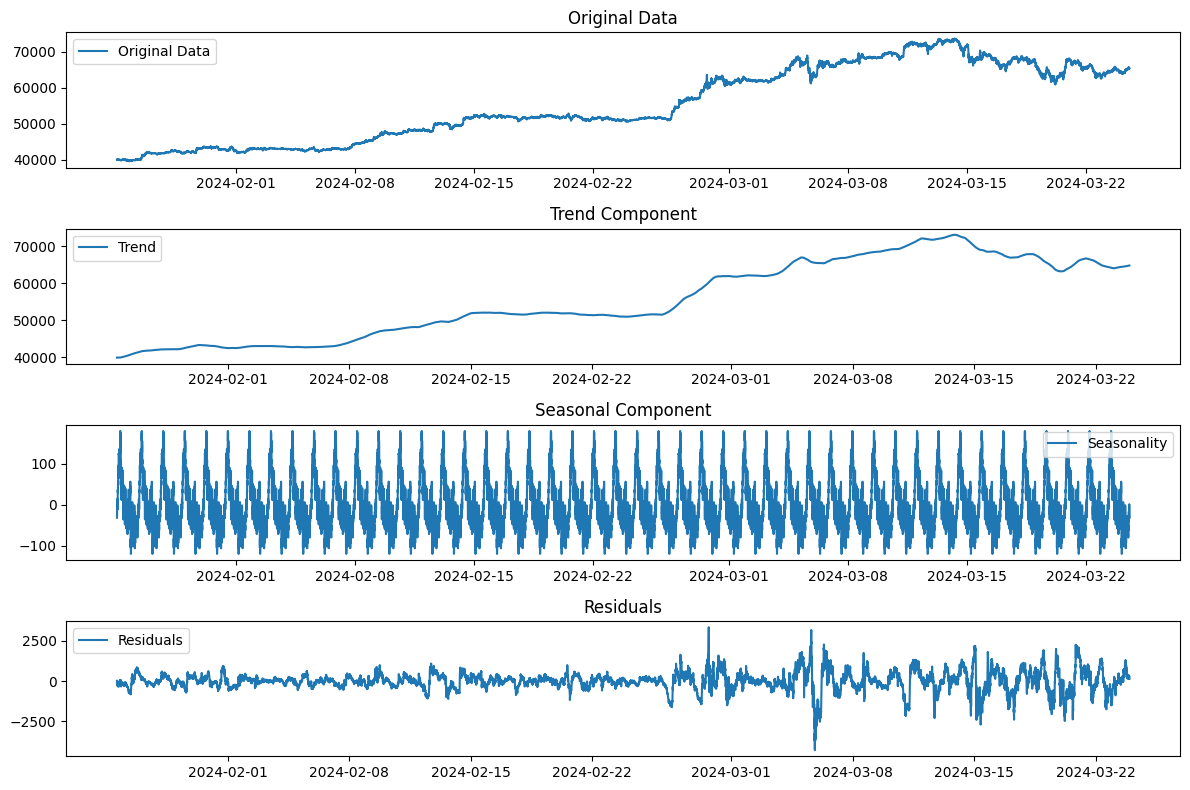

In [ ]:
# STL Decomposition 547
stl_result = sm.tsa.seasonal_decompose(train_data, model='additive', period=365)

# Plot the components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(train_data, label='Original Data')
plt.title('Original Data')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(stl_result.trend, label='Trend')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(stl_result.seasonal, label='Seasonality')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(stl_result.resid, label='Residuals')
plt.title('Residuals')
plt.legend()

plt.tight_layout()
plt.show()

ADF test function

In [ ]:
labels=['Test statistics','P-Value','No of Lags','No of Observations']
def adf_test(close):
    result=adfuller(close)
    for label,value in zip(labels,result):
        print(label," : ",value)
    for i in result[4].items():
        print("Critical value ",pd.Series(i)[0]," : ",pd.Series(i)[1])
    if result[1]<0.05:
        print("P-value less than 0.05, hence Null hypothesis can be rejected\n")
    else:
        print("P-value greater than 0.05, hence Null hypothesis can't be rejected")

In [ ]:
adf_test(train_data)

Test statistics  :  -1.1744905843811402
P-Value  :  0.6844718502238358
No of Lags  :  34
No of Observations  :  17121
Critical value  1%  :  -3.430732003428793
Critical value  5%  :  -2.861708830525976
Critical value  10%  :  -2.566859864147393
P-value greater than 0.05, hence Null hypothesis can't be rejected


Differencing

In [ ]:
adf_test(train_data.diff().dropna())  #order------->1

Test statistics  :  -22.3233708705468
P-Value  :  0.0
No of Lags  :  33
No of Observations  :  17121
Critical value  1%  :  -3.430732003428793
Critical value  5%  :  -2.861708830525976
Critical value  10%  :  -2.566859864147393
P-value less than 0.05, hence Null hypothesis can be rejected



Differencing plots

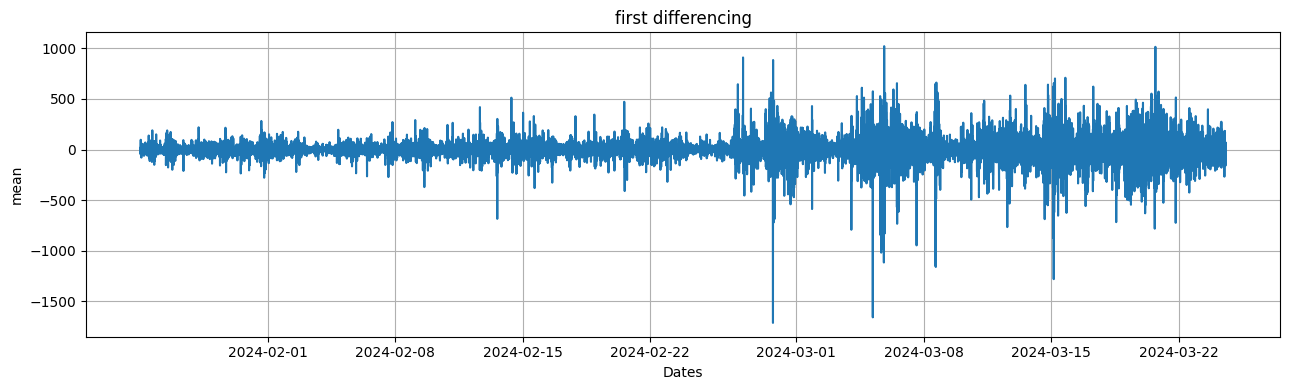

In [ ]:
plt.figure(figsize=(13,4))
plt.plot(train_data.diff().dropna())
plt.ylabel("mean")
plt.xlabel("Dates")
plt.grid(True)
plt.title("first differencing")
plt.tight_layout()
plt.show()

ACF, PACF plots

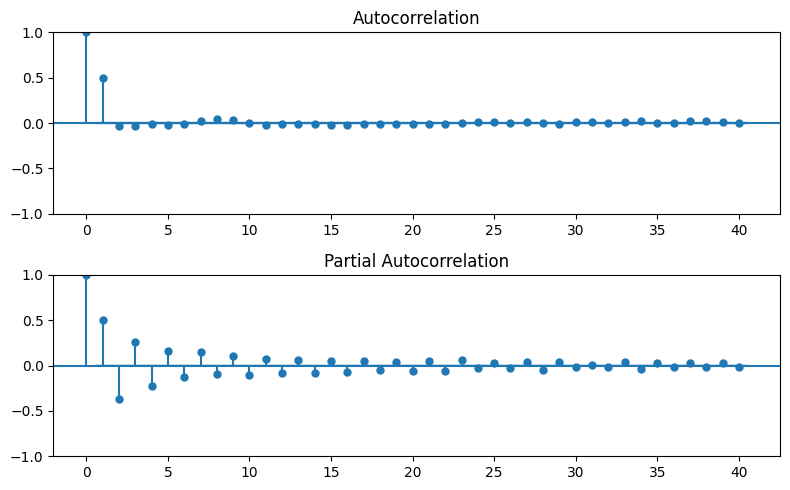

In [ ]:
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(211)
acf=sm.graphics.tsa.plot_acf(train_data.diff(2).dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_data.diff(2).dropna(),lags=40,ax=ax2)
plt.tight_layout()

In [ ]:
#order=(1,1,1),seasonal_order=(1,2,1,2)
model=sm.tsa.statespace.SARIMAX(train_data,order=(2,1,2),seasonal_order=(2,1,2,3))
model_fit=model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                17458
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 3)   Log Likelihood             -115244.138
Date:                           Sun, 24 Mar 2024   AIC                         230506.276
Time:                                   14:33:16   BIC                         230576.182
Sample:                                        0   HQIC                        230529.299
                                         - 17458                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0584      0.022      2.627      0.009       0.015       0.102
ar.L2          0.9404      0.022     42.302

--------------------------------------------GRID SEARCH----------------------------------------------

Finding P,D,Q values using Auto-Arima

In [ ]:
'''model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=3,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0,
                      D=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())'''

"model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,\n                      test='adf',       # use adftest to find optimal 'd'\n                      max_p=5, max_q=5, # maximum p and q\n                      m=3,              # frequency of series\n                      d=None,           # let model determine 'd'\n                      seasonal=True,   # No Seasonality\n                      start_P=0,\n                      D=None,\n                      trace=True,\n                      error_action='ignore',\n                      suppress_warnings=True,\n                      stepwise=True)\nprint(model_autoARIMA.summary())"

Finding best RMSE

Using nested Loops(ARIMA)

In [ ]:
p_values = range(0, 10)  #[0, 1]
d_values = range(0, 3)
q_values = range(0, 5)
smallest_rmse=float('inf')
seasonal_periods = [x for x in range(2,11)]

In [ ]:
'''for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            warnings.filterwarnings("ignore")
            model = sm.tsa.ARIMA(train_data, order=order).fit()
            predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
            error = mean_squared_error(test_data, predictions)
            print('ARIMA%s RMSE=%.3f' % (order,sqrt(error)))
            #finding best RMSE and order
            if sqrt(error)<smallest_rmse:
                smallest_rmse=sqrt(error)
                best_order=order
print('\nSmallest RMSE: %.3f for order %s' %(smallest_rmse,best_order))'''

'for p in p_values:\n    for d in d_values:\n        for q in q_values:\n            order = (p,d,q)\n            warnings.filterwarnings("ignore")\n            model = sm.tsa.ARIMA(train_data, order=order).fit()\n            predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)\n            error = mean_squared_error(test_data, predictions)\n            print(\'ARIMA%s RMSE=%.3f\' % (order,sqrt(error)))\n            #finding best RMSE and order\n            if sqrt(error)<smallest_rmse:\n                smallest_rmse=sqrt(error)\n                best_order=order\nprint(\'\nSmallest RMSE: %.3f for order %s\' %(smallest_rmse,best_order))'

Using nested Loops(SARIMA)

In [ ]:
p_values =  [0]#range(1,2)  #[0, 1]      (0,1,1)(1,0,1)[2]
d_values = [1]#range(1,2)
q_values = [1]#range(1,2)
smallest_rmse=float('inf')
seasonal_periods = [2]#[x for x in range(2,7)]

In [ ]:
'''for p in p_values:
    for d in d_values:
        for q in q_values:
            for seasonal_period in seasonal_periods:
                order = (p, d, q)
                sorder = (0, 0, 0, seasonal_period)
                warnings.filterwarnings("ignore")

                try:
                    model = sm.tsa.statespace.SARIMAX(train_data, order=order, seasonal_order=sorder).fit()
                    predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
                    mse = mean_squared_error(test_data, predictions)
                    rmse = np.sqrt(mse)

                    print('SARIMA%sx%s RMSE=%.3f' % (order, sorder, rmse))

                    # Update smallest_rmse if current error is smaller
                    if rmse < smallest_rmse:
                        smallest_rmse = rmse
                        best_order = order
                        best_seasonal_order = sorder

                except Exception as e:
                    print(f"Error for order {order} and seasonal order {sorder}: {str(e)}")
                    continue

print('\nSmallest RMSE: %.3f for order %s and seasonal order %s' % (smallest_rmse, best_order, best_seasonal_order))'''

'for p in p_values:\n    for d in d_values:\n        for q in q_values:\n            for seasonal_period in seasonal_periods:\n                order = (p, d, q)\n                sorder = (0, 0, 0, seasonal_period)\n                warnings.filterwarnings("ignore")\n\n                try:\n                    model = sm.tsa.statespace.SARIMAX(train_data, order=order, seasonal_order=sorder).fit()\n                    predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)\n                    mse = mean_squared_error(test_data, predictions)\n                    rmse = np.sqrt(mse)\n\n                    print(\'SARIMA%sx%s RMSE=%.3f\' % (order, sorder, rmse))\n\n                    # Update smallest_rmse if current error is smaller\n                    if rmse < smallest_rmse:\n                        smallest_rmse = rmse\n                        best_order = order\n                        best_seasonal_order = sorder\n\n                except Exception

ARIMA model

In [ ]:
#model=sm.tsa.ARIMA(train_data,order=(0, 1, 0))
#model_fit=model.fit()

SARIMA model

In [ ]:
#model=sm.tsa.statespace.SARIMAX(train_data,order=(9, 2, 0),seasonal_order=(2,2,0,30))
#model_fit=model.fit()

In [ ]:
#print(model_fit.summary())

In [ ]:
start_time = train_data.index[-1] + pd.DateOffset(days=3, hours=17, minutes=50)
start_time

Timestamp('2024-02-08 17:50:00')

In [ ]:
test_data.tail(5)

Date
2024-03-15    2836.449951
2024-03-18    2878.949951
2024-03-19    2850.500000
2024-03-20    2887.500000
2024-03-21    2900.050049
Name: Close, dtype: float64

Rolling Forecast(Test data)

In [ ]:
order = (1, 1, 1)
sorder = (1, 1, 1, 3)

In [ ]:
predictions = []
for i in range(len(test_data)):
    # Fit the model with updated training data
    model = sm.tsa.statespace.SARIMAX(np.concatenate([train_data, test_data.iloc[:i]]), order=order,seasonal_order=sorder)
   # model = sm.tsa.statespace.SARIMAX(train_data, order=order,seasonal_order=sorder)
    fit_model = model.fit(disp=False)

    # Make one-step-ahead prediction
    pred = fit_model.get_forecast(steps=1)
    yhat = pred.predicted_mean

    # Save the prediction
    predictions.append(yhat)
    #train_data = train_data.append(pd.Series(yhat.values,index=[test_data.index[i]]))

Rolling Forecast (Future)

In [ ]:
predictions_f = []
# Perform rolling forecast for the next 10 days
forecast_horizon = 10
train_data = df.iloc[:,3]  # Initial training data

In [ ]:
for i in range(len(df),len(df)+forecast_horizon):
    # Fit the model with the current training data
    model = sm.tsa.statespace.SARIMAX(df.iloc[:,3], order=order, seasonal_order=sorder)
    fit_model = model.fit(disp=False)

    # Forecast the next point
    pred = fit_model.get_forecast(steps=1)
    yhat = pred.predicted_mean.values[0]

    # Save the prediction
    predictions_f.append(yhat)

    # Update the training data with the new observation
   # train_data = train_data.append(pd.Series([yhat], index=[train_data.index[-1] + pd.DateOffset(1)]))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

future prediction using step value

In [ ]:
model_c = sm.tsa.statespace.SARIMAX(df.iloc[:,3], order=order,seasonal_order=sorder)
fit_model_c = model_c.fit(disp=False)
pred_c = fit_model_c.get_forecast(steps=10)
yhat_c = pred_c.predicted_mean
yhat_c

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

17176    65597.851825
17177    65601.232388
17178    65600.660575
17179    65602.993560
17180    65605.179431
17181    65605.556087
17182    65607.177919
17183    65610.053986
17184    65609.759059
17185    65612.034331
Name: predicted_mean, dtype: float64

In [ ]:
# prompt: create a time frame for every 5 minutes from the last index of df and assign it to yhat_c

yhat_c = pd.DataFrame(yhat_c)
yhat_c.index = pd.date_range(start=df.index[-1], periods=len(yhat_c), freq='5min')

In [ ]:
yhat_c

,predicted_mean
2024-03-24 15:35:00+00:00,65597.851825
2024-03-24 15:40:00+00:00,65601.232388
2024-03-24 15:45:00+00:00,65600.660575
2024-03-24 15:50:00+00:00,65602.993560
2024-03-24 15:55:00+00:00,65605.179431
2024-03-24 16:00:00+00:00,65605.556087
2024-03-24 16:05:00+00:00,65607.177919
2024-03-24 16:10:00+00:00,65610.053986
2024-03-24 16:15:00+00:00,65609.759059
2024-03-24 16:20:00+00:00,65612.034331


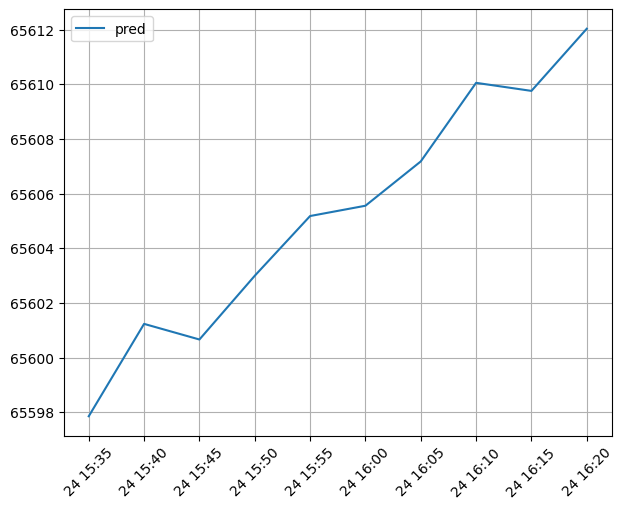

In [ ]:
plt.grid(True)
plt.plot(yhat_c,label='pred')
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
result=pd.DataFrame({"predictions":np.array(predictions).ravel(),"test_data":test_data,"diff": np.array(predictions).ravel()-test_data})
result.round(2)

,predictions,test_data,diff
Datetime,,,
2024-03-24 14:00:00+00:00,65417.46,65453.92,-36.47
2024-03-24 14:05:00+00:00,65455.27,65441.76,13.51
2024-03-24 14:10:00+00:00,65442.21,65534.91,-92.69
2024-03-24 14:15:00+00:00,65537.97,65679.41,-141.44
2024-03-24 14:20:00+00:00,65678.42,65886.79,-208.37
2024-03-24 14:25:00+00:00,65888.54,65745.28,143.26
2024-03-24 14:30:00+00:00,65745.69,65788.75,-43.06
2024-03-24 14:35:00+00:00,65786.96,65590.78,196.18
2024-03-24 14:40:00+00:00,65594.23,65616.34,-22.11


In [ ]:
result=result.round(2).dropna()

In [ ]:
r2=r2_score(result['predictions'],result['test_data'])
rmse=math.sqrt(mean_squared_error(result['predictions'],result['test_data']))
mae=mean_absolute_error(result['predictions'],result['test_data'])
print("R2 :",r2)
print("RMSE :",rmse)
print("MAE :",mae)

R2 : 0.32111215171844865
RMSE : 96.37217797215925
MAE : 78.15563307555276


In [ ]:
a=2
b=15

In [ ]:
from datetime import datetime,timedelta

In [ ]:
future_dates=pd.date_range(start=test_data.index[-1]+timedelta(days=a),end=test_data.index[-1]+timedelta(days=b),freq='D')
future_dates

In [ ]:
weekdays=future_dates[future_dates.to_series().dt.dayofweek < 5]
weekdays

In [ ]:
pd.Series(predictions_f[:10],index=weekdays)

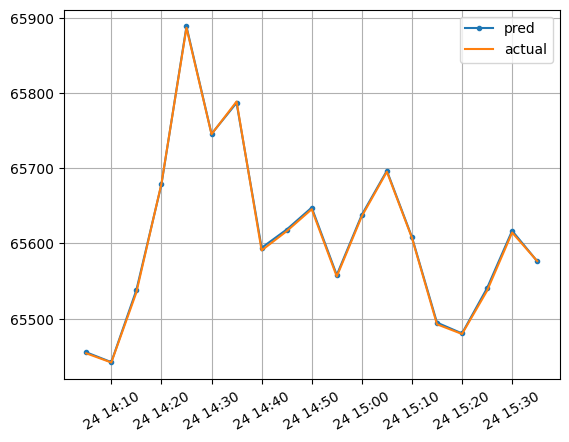

In [ ]:
plt.plot(result.predictions,marker=".",label='pred')
plt.plot(result.test_data,label='actual')
#plt.title("next 10 days Nifty 50")
plt.grid(True)
plt.xticks(rotation=30)
plt.legend()
plt.show()

In [ ]:
plt.plot(pd.concat([pd.Series(test_data.index),pd.Series(weekdays)]),pd.concat([pd.Series(predictions),pd.Series(predictions_f[:10])]),c='red',label="predictions",marker='.')
plt.plot(test_data,c='green',label="actual",marker='.')
plt.xlabel("date")
plt.ylabel("price")
plt.grid(True)
plt.title("Nifty 50")
plt.legend()
plt.xticks(rotation=30)
plt.show()

Future prediction

Seasonal arima

In [ ]:
model_s = sm.tsa.statespace.SARIMAX(df.Close, order=(9,2,1),seasonal_order=(0,0,0,365))
fit_model_s = model_s.fit(disp=False)

In [ ]:
pred_s = fit_model_s.get_forecast(steps=5)
yhat_s = pred_s.predicted_mean

Arima

In [ ]:
model=sm.tsa.ARIMA(df['Close'],order=(9, 2, 1))
model_fit=model.fit()

In [ ]:
pred = fit_model.get_forecast(steps=5)
yhat = pred.predicted_mean

Creating future dates

In [ ]:
future_dates=pd.date_range(start='2024-03-04',end='2024-03-08',freq='D')

In [ ]:
df.Close.tail()

In [ ]:
vs=pd.DataFrame({"date":future_dates,"arima":yhat,"sarima":yhat_s})
vs

In [ ]:
df.Close.tail()

Visualizing future prices

In [ ]:
plt.figure(figsize=(13,6))
plt.subplot(2,3,1)
plt.plot(vs['date'],vs.arima,marker='*',c='red',label="arima")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("ARIMA")
plt.legend()

plt.subplot(2,3,2)
plt.plot(vs['date'],vs.sarima,marker='*',c='green',label="sarima")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.title("SARIMA")
plt.grid(True)

plt.subplot(2,3,3)
plt.plot(df.index[-5:],df.Close.tail(),marker='*',c='purple',label="previous")
plt.tight_layout()
plt.xticks(rotation=45)
plt.grid(True)
plt.title("PREVIOUS")
plt.legend()
plt.show()